In [90]:
import pandas as pd
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [27]:
# import csv
wiki_feat = pd.read_csv('../WebScraper/wikiarticles.csv')
wiki_feat = wiki_feat.set_index('article_name') #set article name as index
wiki_feat['date_article_creation'] = wiki_feat['date_article_creation'].str[7:] #strip time

# clean up column 'date_article_creation' and make 'days_since_creation'
wiki_feat['date_article_creation']= pd.to_datetime(wiki_feat['date_article_creation'], errors='coerce')
today = pd.to_datetime(dt.date.today())
wiki_feat['days_since_creation'] = (today - wiki_feat['date_article_creation']) / pd.Timedelta(1, 'D') # convert timedelta object to pure day by dividing by 1 d

In [84]:
lang_nums = [] # target
ref_counts = [] # feat2
body_text_lens = [] # feat3
main_article_num = [] # feat4
see_also_num = [] # feat5
further_info_num = [] # feat6
table_text_lens = [] # feat7
sports = [] # feat8
# exec_counter = 0

for article in wiki_feat.index:
    filename = "../wikiarticles/" + article + ".html"
    html_handle = open(filename)
    html_text = html_handle.read()
    soup = BeautifulSoup(html_text, 'lxml')

    # filling list for target
    lang_section = soup.find("nav", {"id":"p-lang"})
    lang_num = len(lang_section.find_all('li'))
    lang_nums.append(lang_num)

    # filling list for feature 2, extract number of references from html
    try:
        ref_count = len(soup.find('ol', class_='references').find_all('li'))
    except AttributeError: #when there are no references
        ref_count = 0
    ref_counts.append(ref_count)
    
    # use for finding features 3-6
    body_text = soup.find("div", {"id":"mw-content-text"}).text

    # filling list for feature 3, extract length of body text
    len_body_text = len(body_text)
    body_text_lens.append(len_body_text)

    # find all occurances of "Main article:" or "Main articles:" (feat 4)
    main_article_count = 0
    for main_article in re.finditer('Main article:', body_text):
        main_article_count += 1
    for main_articles in re.finditer('Main articles:', body_text):
        main_article_count += 1
    main_article_num.append(main_article_count)

    # find all occurances of "See also:" (feat 5)
    see_also_count = 0
    for see_also in re.finditer('See also:', body_text):
        see_also_count += 1
    see_also_num.append(see_also_count)

    # find all occurnaces of "Further information:" (feat 6)
    further_info_count = 0
    for further_info in re.finditer('Further info:', body_text):
        further_info_count += 1
    further_info_num.append(further_info_count)

    # find all text within any tables, and find length (feat 7)
    table_list = soup.find_all("table")
    table_text_len = 0
    for element in table_list:
        table_text_len += len(element.text)
    table_text_lens.append(table_text_len)

    # is this article sports? (feat 8)
    category_text = soup.find("div", {"id":"mw-normal-catlinks"}).text
    sport_list = ['Baseball', 'baseball', 'Basketball', 'basketball', 'Football', 'football', 'Soccer', 'soccer', 'Hockey', 'hockey', 'Volleyball', 'volleyball', 'Tennis', 'tennis', 'Cricket', 'cricket', 'Golf', 'golf']
    sports_bool = 0
    for sport in sport_list:
        if re.findall(sport, category_text) != []:
            sports_bool = 1
    sports.append(sports_bool)

    # exec_counter += 1
    # print(exec_counter)

wiki_feat['languages'] = lang_nums
wiki_feat['references'] = ref_counts
wiki_feat['text_length'] = body_text_lens
wiki_feat['main_article_num'] = main_article_num
wiki_feat['see_also_num'] = see_also_num
wiki_feat['further_info_num'] = further_info_num
wiki_feat['table_text_len'] = table_text_lens
wiki_feat['sports'] = sports

In [80]:
# wiki_feat.sort_values(by='languages', ascending=False).head(10)

# playground
filename = "../wikiarticles/Marcelo Peterson.html"
html_handle = open(filename)
html_text = html_handle.read()
soup = BeautifulSoup(html_text, 'lxml')


0


In [105]:
wiki_feat.dropna(inplace=True)
wiki_feat.drop(columns = ['further_info_num'], inplace=True);

&lt;matplotlib.collections.PathCollection at 0x7fb215e1cb80&gt;

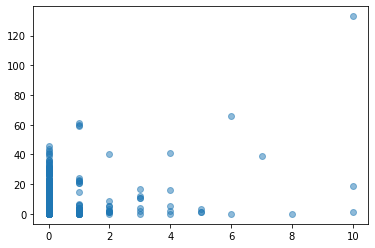

In [33]:


%matplotlib inline

plt.scatter(wiki_feat['main_article_num'],wiki_feat['languages'], alpha=0.5)

In [106]:
wiki_feat.corr()

,days_since_creation,languages,references,text_length,main_article_num,see_also_num,table_text_len,sports
days_since_creation,1.000000,0.017927,0.005343,0.037096,-0.011478,0.050958,0.016747,0.017038
languages,0.017927,1.000000,0.130669,0.270151,0.287598,0.078302,0.081050,0.004269
references,0.005343,0.130669,1.000000,0.671093,0.380489,0.242230,0.112611,0.041319
text_length,0.037096,0.270151,0.671093,1.000000,0.452582,0.379830,0.462365,0.065922
main_article_num,-0.011478,0.287598,0.380489,0.452582,1.000000,0.361828,0.147041,0.122753
see_also_num,0.050958,0.078302,0.242230,0.379830,0.361828,1.000000,0.129391,0.051565
table_text_len,0.016747,0.081050,0.112611,0.462365,0.147041,0.129391,1.000000,0.074799
sports,0.017038,0.004269,0.041319,0.065922,0.122753,0.051565,0.074799,1.000000


In [88]:
# Create an empty model
lr_full = LinearRegression()

# Features
X = wiki_feat.loc[:, ['days_since_creation','references','text_length', 'main_article_num', 'see_also_num','table_text_len', 'sports']]

# Target
y = wiki_feat['languages']

# Fit  
lr_full.fit(X, y)

# Score
lr_full.score(X, y)

0.12707808893819428

In [107]:
p = PolynomialFeatures()
X_poly = p.fit_transform(X)

lr_full = LinearRegression()
lr_full.fit(X_poly, y)
lr_full.score(X_poly, y)

0.29558796438343304